In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import yfinance as yf
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression







In [106]:
from pathlib import Path
import pandas as pd


user = 'omarlodhi'

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_4/figures'


# preprocessing data


# Define the path to the directory containing the CSV files
investing_data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_4/data/investing.com')
FRED_data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_4/data/FRED')



dataframes = {}

for csv_file in investing_data_path.glob("*.csv"):
    file_name = csv_file.stem
    df = pd.read_csv(csv_file)

    if 'Date' in df.columns and 'Price' in df.columns:
        df = df[['Date', 'Price']]
        df.rename(columns={'Price': file_name}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values(by='Date', ascending=False, inplace=True)

        dataframes[file_name] = df  # Store in dictionary instead of globals()

# Ensure 'observation_date' exists before renaming

# Iterate over each CSV file in the directory
for csv_file in FRED_data_path.glob("*.csv"):
    file_name = csv_file.stem  # Get the file name without the extension
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    if 'observation_date' in df.columns:
        df.rename(columns={'observation_date': 'Date'}, inplace=True)
        
        # Rename all other columns to match the file name
        for col in df.columns:
            if col != 'Date':  # Keep 'Date' as is
                df.rename(columns={col: file_name}, inplace=True)
        
        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Sort by date in ascending order
        df.sort_values(by='Date', ascending=False, inplace=True)
        
        # Store DataFrame in dictionary
        dataframes[file_name] = df



df_total = pd.DataFrame()

for df in dataframes.values():
    if df_total.empty:
        df_total = df
    else:
        df_total = pd.merge(df_total, df, on='Date', how='inner')

print(df_total.columns)

df_total['spy'] = df_total['spy'].replace({',': ''}, regex=True).astype(float)

df_total['prop'] = (df_total['size'] / (1000000)) / 27

df_total['curve'] = (df_total['10yr_yield'] - df_total['2yr_yield']) * 100

print(df_total.shape)

df_total['inflation_curve'] = df_total['10y_BE'] - df_total['5y_BE']



Index(['Date', 'spy', 'move_index', '5yr_yield', '3yr_swap_rate',
       '3m_treasury_ffr_spread', '6_treasury_ffr_spread', '5y_BE',
       'policy_rate', 'corporate_a_ffr_spread', '2yr_BE', '30yr_swap_rate',
       '4yr_swap_rate', 'corporate_ffr_spread', '3yr_yield', '30yr_yield',
       'corporate_spread', '5yr_swap_rate', '5r_swap_rate', '2yr_swap_rate',
       '5yr_treasury_minus_ffr', '1yr_treasury_minus_ffr', '6yr_yield',
       '1yr_yield', '7yr_swap_rate', '10yr_swap_rate', '10yr_yield',
       'comm_paper_ffr_spread', '10y_BE', '7yr_yield', '5y5y_BE',
       '1yr_swap_rate', 'vix', '10yr_tp', '2yr_yield', 'dollar_index', 'size'],
      dtype='object')
(82, 39)


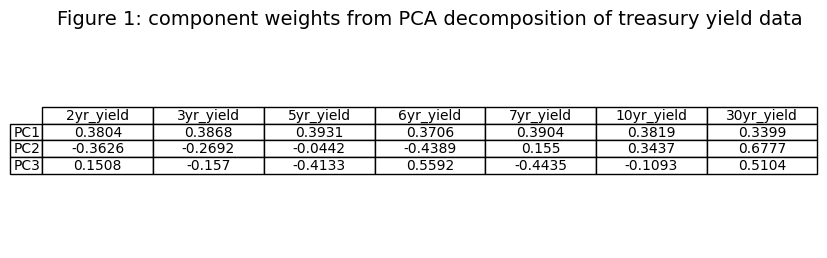

        PC1       PC2
0 -2.312712 -1.393814
1 -2.476855 -1.350543
2 -2.576078 -1.334833
3 -1.831358 -1.014762
4 -2.036589 -0.965796


In [110]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define PCA columns
pca_columns = ['2yr_yield', '3yr_yield', '5yr_yield', '6yr_yield', '7yr_yield', '10yr_yield', '30yr_yield']

# Standardize the data
df_pca = df_total[pca_columns].dropna()  # Drop NaN values to ensure PCA works
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Perform PCA
pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_scaled)  # Get PC1, PC2 values

# Merge PC scores (PC1, PC2) back into df_total
df_total['PC1'] = pc_scores[:, 0]
df_total['PC2'] = pc_scores[:, 1]
df_total['PC3'] = pc_scores[:, 2]

# Define the function to plot PCA component weights as a table
def plot_pca_component_weights(pca, feature_names, title="PCA Component Weights", figure_path=None):
    """
    Plots a table of PCA component weights and saves it to a file if figure_path is provided.
    
    Parameters:
    pca: Fitted PCA object
    feature_names: List of feature names corresponding to components
    title: Custom title for the table
    figure_path: Path to save the figure (optional)
    """
    component_weights = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    fig, ax = plt.subplots(figsize=(10, len(feature_names) * 0.4))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=component_weights.round(4).values,
             colLabels=component_weights.columns,
             rowLabels=component_weights.index,
             cellLoc='center', loc='center')
    
    plt.title(title, fontsize=14)

    # Save to file if figure_path is specified
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')

    plt.show()

# Define figure path (ensure the directory exists)
figure_with_name = os.path.join(figure_path, 'figure_1.jpg')

# Plot and save PCA component weights
plot_pca_component_weights(pca, pca_columns, title="Figure 1: component weights from PCA decomposition of treasury yield data", figure_path=figure_with_name)

# Verify the merged DataFrame
print(df_total[['PC1', 'PC2']].head())  # Display the first few rows to check the merge




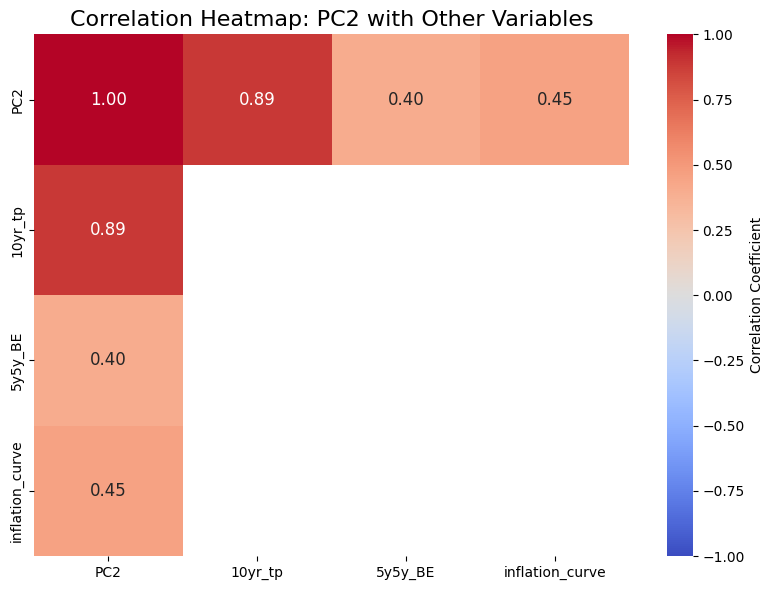

In [108]:
# figure 2  


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the columns of interest (PC2 and the other variables)
correlation_columns = ['PC2', '10yr_tp', '5y5y_BE', 'inflation_curve']

# Compute the correlation matrix (only for PC2 and the selected variables)
correlation_matrix = df_total[correlation_columns].corr()

# Since you want to show only PC2's correlation with other variables (not their correlations with each other),
# we will mask the upper triangle and lower triangle of the matrix to hide those correlations.
correlation_matrix_no_off_diagonal = correlation_matrix.copy()
# Set all non-PC2 correlations to NaN (remove off-diagonal values)
correlation_matrix_no_off_diagonal.iloc[1:, 1:] = None

# Step 2: Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_no_off_diagonal, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 12}, fmt='.2f')

# Step 3: Customize the plot
plt.title('Correlation Heatmap: PC2 with Other Variables', fontsize=16)
plt.tight_layout()

# Step 4: Show the plot
plt.show()



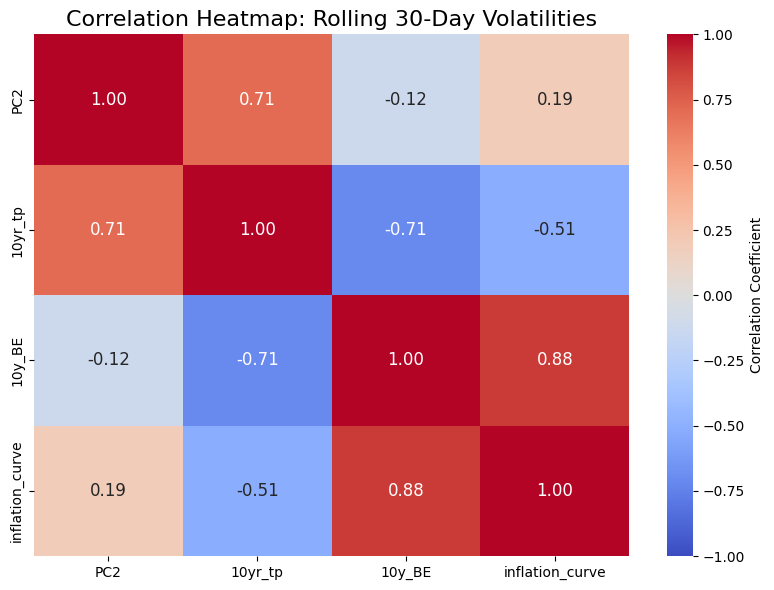

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the columns of interest (PC2 and the other variables)
correlation_columns = ['PC2', '10yr_tp', '10y_BE', 'inflation_curve']

# Step 1: Calculate the rolling 30-day standard deviation (volatility) for each of the variables
df_volatility = df_total[correlation_columns].rolling(window=30).std()

# Step 2: Compute the correlation matrix of these rolling volatilities
correlation_matrix_volatility = df_volatility.corr()

# Step 3: Plot the heatmap for the rolling volatility correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_volatility, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 12}, fmt='.2f')

# Step 4: Customize the plot
plt.title('Correlation Heatmap: Rolling 30-Day Volatilities', fontsize=16)
plt.tight_layout()

# Step 5: Show the plot
plt.show()


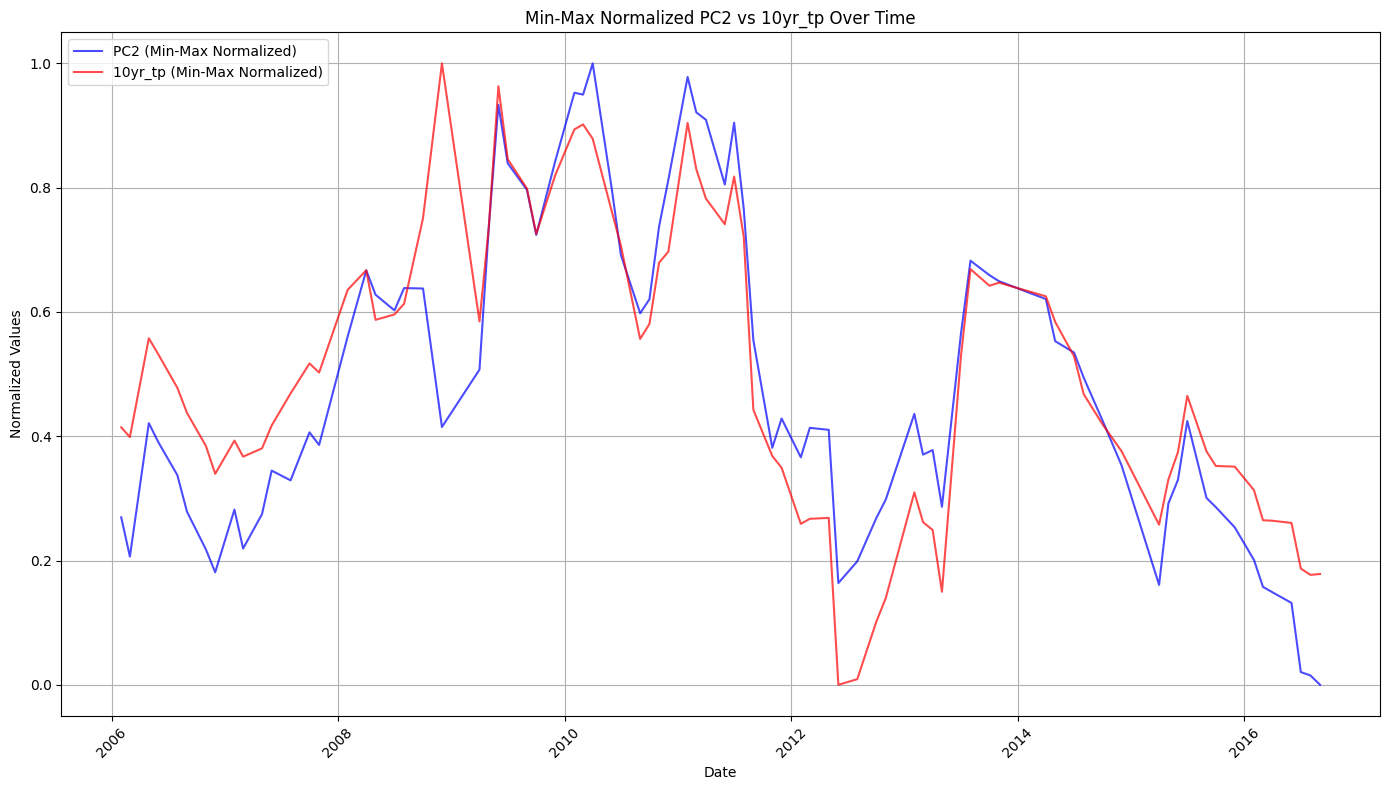

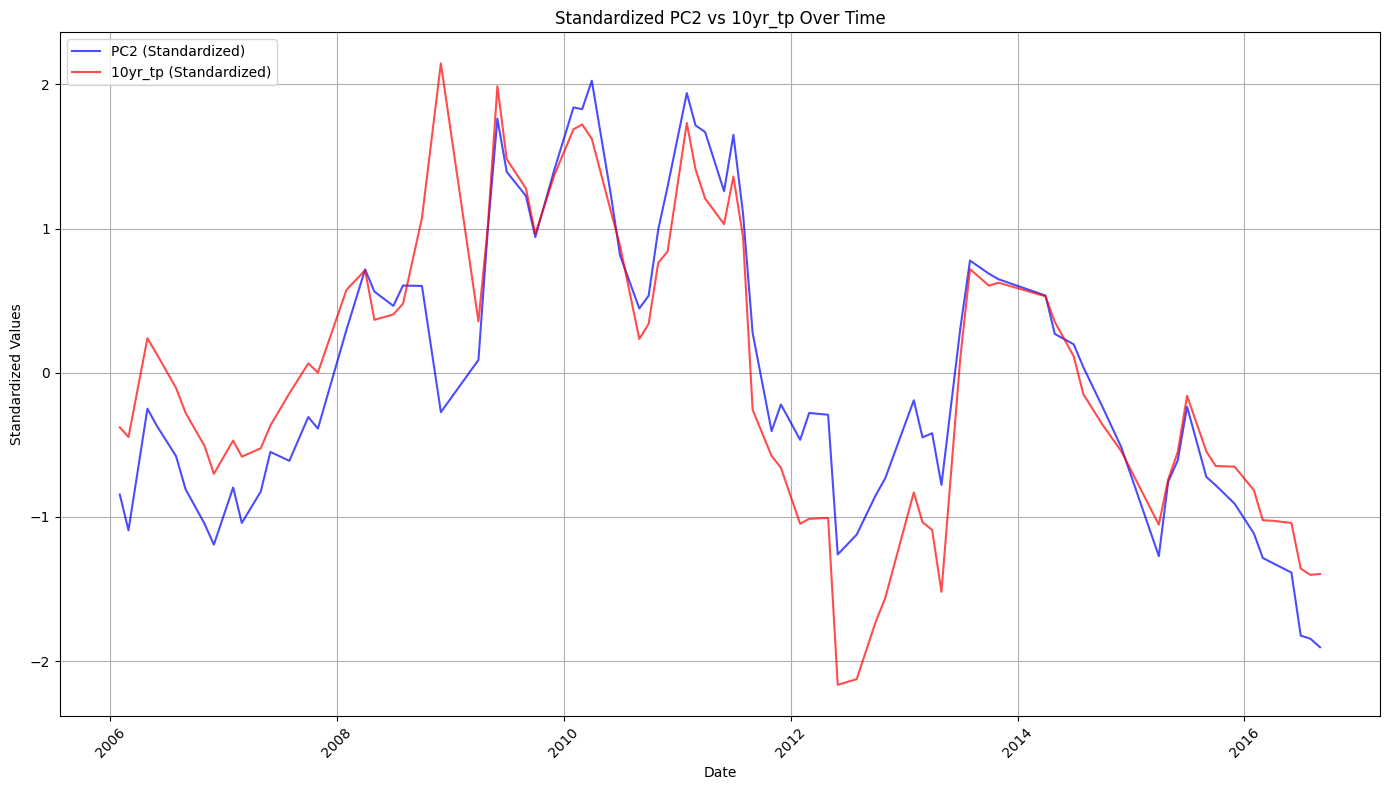

In [112]:
# Step 1: Normalize both PC2 and 10yr_tp using Min-Max Scaling (range between 0 and 1)
df_total['PC2_normalized_minmax'] = min_max_scaler.fit_transform(df_total[['PC2']])
df_total['10yr_tp_normalized_minmax'] = min_max_scaler.fit_transform(df_total[['10yr_tp']])

# Step 2: Plot PC2 vs 10yr_tp (both normalized using Min-Max scaling) over time
plt.figure(figsize=(14, 8))

# Plot for Min-Max Normalized values
plt.plot(df_total['Date'], df_total['PC2_normalized_minmax'], label='PC2 (Min-Max Normalized)', color='blue', alpha=0.7)
plt.plot(df_total['Date'], df_total['10yr_tp_normalized_minmax'], label='10yr_tp (Min-Max Normalized)', color='red', alpha=0.7)

# Step 3: Customize the plot
plt.title('Min-Max Normalized PC2 vs 10yr_tp Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Step 4: Show the plot
plt.show()

# Step 5: Alternatively, you can use Standardized values as well
df_total['PC2_normalized_standard'] = standard_scaler.fit_transform(df_total[['PC2']])
df_total['10yr_tp_normalized_standard'] = standard_scaler.fit_transform(df_total[['10yr_tp']])

# Step 6: Plot for Standardized values
plt.figure(figsize=(14, 8))

# Plot for Standardized values
plt.plot(df_total['Date'], df_total['PC2_normalized_standard'], label='PC2 (Standardized)', color='blue', alpha=0.7)
plt.plot(df_total['Date'], df_total['10yr_tp_normalized_standard'], label='10yr_tp (Standardized)', color='red', alpha=0.7)

# Step 7: Customize the plot
plt.title('Standardized PC2 vs 10yr_tp Over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Step 8: Show the plot
plt.show()


PCA Loadings:
              PC1   PC2
10yr_tp      0.71  0.71
policy_rate -0.71  0.71


/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_85318/2437867870.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pc1 = df_total.groupby('PC1_group')[variables].mean()
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_85318/2437867870.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pc2 = df_total.groupby('PC2_group')[variables].mean()


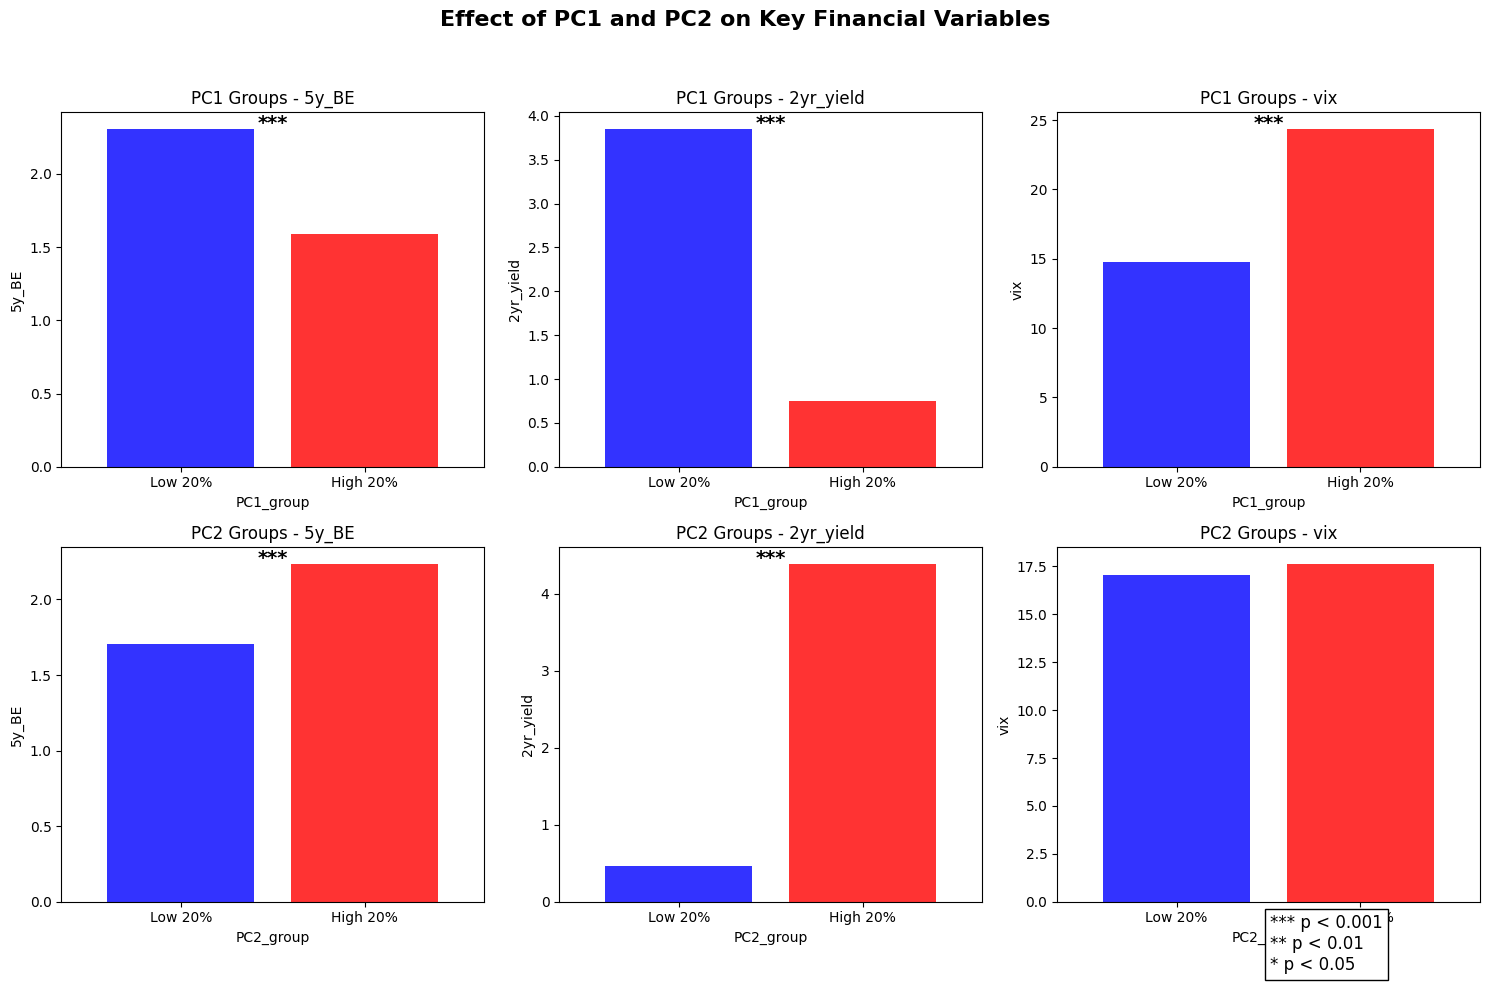

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Select variables for PCA
pca_columns = ['10yr_tp', 'policy_rate']
df_pca = df_total[pca_columns].dropna()

# Step 2: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Step 3: Perform PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(df_scaled)

# Step 4: Extract Loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=pca_columns)
print("PCA Loadings:")
print(loadings.round(2))

# Step 5: Add PC1 and PC2 back to the original dataset
df_pca['PC1'] = pc_scores[:, 0]
df_pca['PC2'] = pc_scores[:, 1]
df_total = df_total.merge(df_pca[['PC1', 'PC2']], left_index=True, right_index=True, how='left')

# Define PC1 and PC2 Groups (Only Keep Bottom 20% and Top 20%)
df_total['PC1_group'] = pd.qcut(df_total['PC1'], q=[0, 0.2, 0.8, 1], labels=['Low 20%', 'middle1', 'High 20%'])
df_total['PC2_group'] = pd.qcut(df_total['PC2'], q=[0, 0.2, 0.8, 1], labels=['Low 20%', 'middle1', 'High 20%'])

# Compute Averages
variables = ['5y_BE', '2yr_yield', 'vix']
avg_pc1 = df_total.groupby('PC1_group')[variables].mean()
avg_pc2 = df_total.groupby('PC2_group')[variables].mean()

# Keep only Low 20% and High 20%
avg_pc1 = avg_pc1.loc[['Low 20%', 'High 20%']]
avg_pc2 = avg_pc2.loc[['Low 20%', 'High 20%']]

# Perform t-tests for significance
def significance_test(var, group_col):
    """Performs t-test and returns significance level as a string."""
    low_group = df_total[df_total[group_col] == 'Low 20%'][var].dropna()
    high_group = df_total[df_total[group_col] == 'High 20%'][var].dropna()
    
    # Perform t-test
    t_stat, p_val = ttest_ind(low_group, high_group, equal_var=False)
    
    # Determine significance level
    if p_val < 0.001:
        return '***'  # p < 0.001
    elif p_val < 0.01:
        return '**'   # p < 0.01
    elif p_val < 0.05:
        return '*'    # p < 0.05
    else:
        return ''

# Compute significance for each variable
sig_pc1 = {var: significance_test(var, 'PC1_group') for var in variables}
sig_pc2 = {var: significance_test(var, 'PC2_group') for var in variables}

# Define colors for each category
colors = {'Low 20%': 'blue', 'High 20%': 'red'}

# Create Panel of 6 Subplots (Independent y-axis)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot for PC1 (Top row)
for i, var in enumerate(variables):
    bars = avg_pc1[var].plot(kind='bar', ax=axes[0, i], color=[colors[x] for x in avg_pc1.index], alpha=0.8, width=0.8)
    axes[0, i].set_title(f'PC1 Groups - {var}')
    axes[0, i].set_ylabel(var)
    axes[0, i].set_xticklabels(avg_pc1.index, rotation=0)

    # Add significance markers
    y_max = avg_pc1[var].max()
    axes[0, i].text(0.5, y_max, sig_pc1[var], ha='center', fontsize=14, fontweight='bold')

# Plot for PC2 (Bottom row)
for i, var in enumerate(variables):
    bars = avg_pc2[var].plot(kind='bar', ax=axes[1, i], color=[colors[x] for x in avg_pc2.index], alpha=0.8, width=0.8)
    axes[1, i].set_title(f'PC2 Groups - {var}')
    axes[1, i].set_ylabel(var)
    axes[1, i].set_xticklabels(avg_pc2.index, rotation=0)

    # Add significance markers
    y_max = avg_pc2[var].max()
    axes[1, i].text(0.5, y_max, sig_pc2[var], ha='center', fontsize=14, fontweight='bold')

# Overall Figure Title
fig.suptitle("Effect of PC1 and PC2 on Key Financial Variables", fontsize=16, fontweight='bold')

# Add Significance Legend
fig.text(0.85, 0.02, "*** p < 0.001\n** p < 0.01\n* p < 0.05", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title
plt.show()


